In [1]:
#import packages
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision.transforms.functional as F
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import pathlib
from torch.utils.data import Dataset

import numpy as np
#from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch
import torchvision
#from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import resnet50, ResNet50_Weights


#gradcam
import cv2


In [2]:
#good practice to provide class labels as integer arrays

CLASSES = ["BLD", "No BLD"]
class_mapping = {label: idx for idx, label in
                 enumerate(np.unique([CLASSES]))}


In [3]:
#dictonary to modify transformations
config = dict(
    rot=90,
    noise=0.05
)

In [4]:
#make sure image input size matches expected size for the spcific models

train_transform = transforms.Compose(
    #384x384 for efficientnet
    #224x225 for ResNEt and MobileNEt
    #256x256 for Swin
    [transforms.Resize([224,224]), #converts image to the pre-trained model dimension expectations
     #transforms.RandomRotation(degrees=config["rot"]),
     #transforms.RandomVerticalFlip(p=0.5),
     #transforms.RandomHorizontalFlip(p=0.5),
     transforms.Grayscale(3),
     transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),#this is a standard RGB mean and std
    ])

#validation preprocessing
val_transform = transforms.Compose(
    [transforms.Resize([224,224]), #converts image to the pre-trained model dimension expectations
     transforms.Grayscale(3),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),#this is a standard RGB mean and std
     ])
     

In [5]:
#import data
#images in directories converted to tensor format and classes obtained from direcory names
#add test folder once get more data

train_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/train', transform=train_transform)
#test_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/test', transform=val_transform)
val_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/val', transform=val_transform)

In [6]:
# Access the transformed image
image, label = train_dataset[0]
# Check the size of the transformed image
print(image.shape) #retuns [channel, height, width]. 3 indicates color. During training an additional element is added, batch_size


torch.Size([3, 224, 224])


In [7]:
#check class names
train_dataset.class_to_idx

{'BLD': 0, 'No_BLD': 1}

In [8]:
#check number of images in each set
print(f'Number of images in training dataset: {len(train_dataset)}')
#print(f'Number of images in testing dataset: {len(test_dataset)}')
print(f'Number of images in validation dataset: {len(val_dataset)}')

Number of images in training dataset: 82
Number of images in validation dataset: 26


In [9]:
#Bing
#how to print example of each image class from dataset pytorch
#loop through and get one image per class

# Create a dictionary to store one example per class
class_examples = {}

# Iterate through the dataset to find one example per class
#unpack img and label pair from train_dataset
for img, label in train_dataset:
    if label not in class_examples:
        #if the label is not in the class_example dict, then store the image
        class_examples[label] = img
        #if the number of classes in class_examples equals the number of classes in the train_dataset, stop
    if len(class_examples) == len(train_dataset.classes):
        break  

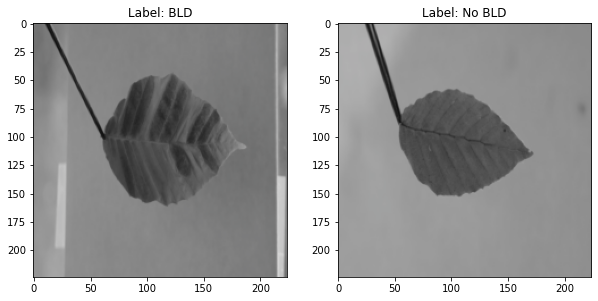

In [10]:
#plot one image from each class in dict 'class_example'
fig = plt.figure(figsize=(10,6))
for label, img in class_examples.items():
    #the dict structure is class label: image
    #print(img)
    #print(label)
    #print(f"Labels batch shape (number): {label.size()}")

    #create subplot shape
    ax = fig.add_subplot(1,2, label+1)
    img = img.numpy().transpose((1, 2, 0)) #changing the channel and dimension order for plotting
    #img = img.numpy().transpose((0, 1, 2))
    #print({img.size})
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    label = label
    ax.imshow(img, cmap="gray")
    #print class title
    ax.set_title(f"Label: {CLASSES[label]}")
plt.show()
   

In [10]:
#a hyperparameter to try changing
#batch_size = 4
batch_size = 16
#batch_size = 32

In [11]:
#dataloader
#output a batch of images and labels, one sample at a time

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
#testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
#                                         shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=True)



In [12]:
#print class for each sample in batch
train_features, train_labels = next(iter(trainloader))
print(train_labels)

tensor([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1])


Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape (number): torch.Size([16])


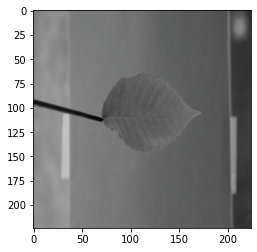

Label: ['No BLD']
Label: 1


In [14]:
# Display image and label.
#to pull out a single image and label, first put in individual variables
#https://stackoverflow.com/questions/61480762/python-matplotlib-invalid-shape-for-image-data

train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape (number): {train_labels.size()}")
img = train_features[0].numpy().transpose((1, 2, 0)) #changing the channel and dimension order for plotting
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {[CLASSES[label]]}")
print(f"Label: {train_labels[0]}")

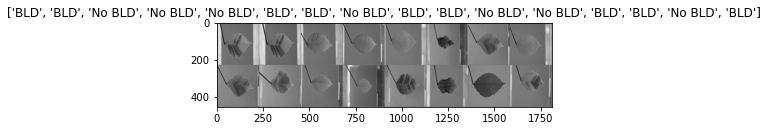

tensor([0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0])


In [15]:
#print the batch inmages and labels

#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[CLASSES[x] for x in classes])
print(classes)

In [13]:
#Import model for training

#ResNet101 
#weights = ResNet101_Weights.DEFAULT
#model_RN = torchvision.models.resnet101(weights=weights)

weights = ResNet50_Weights.DEFAULT
model_RN = torchvision.models.resnet50(weights=weights)

In [14]:
#ResNet
#Intitalize model, not freezing layers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#freeze layers
for param in model_RN.parameters():
    param.requires_grad = False

model_rn = model_RN
num_ftrs = model_rn.fc.in_features #print this out to confirm a value

num_classes = 2  # Replace with the number of classes in your dataset
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_rn.fc = nn.Linear(in_features=model_rn.fc.in_features, out_features=num_classes)

model_rn = model_rn.to(device) #move model to this device



#Loss function

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss() #recommended for binary classificaion


# Observe that all parameters are being optimized
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
optimizer = optim.Adam(model_rn.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
# clear memory cache
torch.cuda.empty_cache()

In [23]:
#Pg. 479 pytorch book
#modified to accomidate BCELoss format expectations in the pred output
#Pg. 473
#If returning 1 probablity from model(x_batch) (using [:,0]), then use BCE function
#If retunring 2 proabability values, use Cross entropy loss function

def train_1(model, num_epochs, train_d1, valid_d1):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train() #set model to training mode
        for x_batch, y_batch, in train_d1:
            #output of forward pass a tensor with predictions for the batch
            pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
            #print(pred.size(), y_batch.size()) #use this to troubleshoot BCE error. Shapes should match
        
        #uncomment block
            loss = criterion(pred, y_batch.float()) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float() #calculating correct class from first column of pred tensor [:,0]
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_d1.dataset)
        accuracy_hist_train[epoch] /= len(train_d1.dataset)
        
        model.eval() 
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for x_batch, y_batch in valid_d1:
                pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
                 #save probabilities from previously trained model
                outputs = model(x_batch)
                #print(f'pred {pred}')
                
                #saving largest probabilities in each batch
                #probabilities in logit format (from BCELoss)
                probs, preds = torch.max(outputs,1) 
                #print(f'preds {preds}')
                #print(f'probs {probs}')
                
                probability = torch.sigmoid(pred)
                #probability = torch.sigmoid(outputs)[0]
                #print(f'probability {probability}')
                #print(f'true labels {y_batch}')
                
                
               #uncomment block
                loss = criterion(pred, y_batch.float()) #BCE expects floar
                loss_hist_valid[epoch] += \
                    loss.item() * y_batch.size(0)
                is_correct = \
                    ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_d1.dataset)
            accuracy_hist_valid[epoch] /= len(valid_d1.dataset)

            #Preparing data for evaluation
            #append values in list after loop   
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            #print(f'all preds 1 {all_preds}')
            #print(f'all labels 1 {all_labels}')
            
            #convert to np array  
            #all_preds = np.array(all_preds)
            #all_labels = np.array(all_labels)

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
            
            #all_preds = torch.tensor(all_preds)
            #all_labels = torch.tensor(all_labels)
            #print(f'all preds {all_preds}')
            #print(f'all labels {all_labels}')
        

        #uncomment block
        print(f'Epoch {epoch+1} '
              f'accuracy: {accuracy_hist_train[epoch]:.4f}, '
              f'val_accuracy: {accuracy_hist_valid[epoch]:.4f}, '
              f'train_loss: {loss_hist_train[epoch]:.4f}, '
              f'val_loss: {loss_hist_valid[epoch]:.4f} ')

            

    # Compute precision
    precision = precision_score(all_labels, all_preds, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
    #calculate recall score
    recall = recall_score(all_labels, all_preds, average='binary')
    #Calculate f1 score
    f1 = f1_score(all_labels, all_preds, average='binary')

    # Calculate ROC AUC
    #need to confirm if sigmoid function is needed (all_predictions vs all_preds
    #auc = roc_auc_score(all_labels, all_predictions)
    auc = roc_auc_score(all_labels, all_preds)
        
                    

    print(f'Precision Score: {precision:.4f}, '
          f'Recall Score: {recall:.4f}, '
          f'F1 Score: {f1:.4f}, '
          f'ROC AUC: {auc:.4f}'
            )    

    #for graph
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds) 
    roc_auc = metrics.auc(fpr, tpr)
    
    # Plot the ROC curve
    #plt.figure()  
    #plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    #plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('ROC Curve for Beech Leaf Disease Classification')
    #plt.legend()
    #plt.show()

    #returns these values that can be stored in a variable when the function is run
    return loss_hist_train, loss_hist_valid, \
        accuracy_hist_train, accuracy_hist_valid, \
        precision, recall, f1, fpr, tpr, auc

In [49]:
#Pg. 479 pytorch book
#modified to accomidate BCELoss format expectations in the pred output
#Pg. 473
#If returning 1 probablity from model(x_batch) (using [:,0]), then use BCE function
#If retunring 2 proabability values, use Cross entropy loss function

def train_1(model, num_epochs, train_d1, valid_d1):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train() #set model to training mode
        for x_batch, y_batch, in train_d1:
            #output of forward pass a tensor with predictions for the batch
            
            pred_train = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
            outputs = model(x_batch)
            
            #print(pred.size(), y_batch.size()) #use this to troubleshoot BCE error. Shapes should match
        
        #uncomment block
            loss = criterion(pred_train, y_batch.float()) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct_train = ((pred_train>=0.5).float() == y_batch).float() #calculating correct class from first column of pred tensor [:,0]
            #print(f'is correct train {is_correct_train}')
            accuracy_hist_train[epoch] += is_correct_train.sum()
        loss_hist_train[epoch] /= len(train_d1.dataset)
        accuracy_hist_train[epoch] /= len(train_d1.dataset)
        #print(f'train accuracy {accuracy_hist_train}')
        
        model.eval() 
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for x_batch, y_batch in valid_d1:
                pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
                 #save probabilities from previously trained model
                outputs = model(x_batch)
                #print(f'pred {pred}')
                
                #predsin = model(x_batch).round()
                #print(f' predsin {predsin}')
                #accura = (predsin == y_batch).float().mean()
                #print(f'accura {accura}')
                
                
                #saving largest probabilities in each batch
                #probabilities in logit format (from BCELoss)
                probs, preds = torch.max(outputs,1) 
                #print(f'preds {preds}')
                #print(f'probs {probs}')
                _, p = argmax(outputs)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)


                
                probability = torch.sigmoid(preds)
                #probability = torch.sigmoid(outputs)[0]
                print(f'probability {probability}')
                #print(f'true labels {y_batch}')
                
                
               #uncomment block
                loss = criterion(pred, y_batch.float()) #BCE expects floar
                loss_hist_valid[epoch] += \
                    loss.item() * y_batch.size(0)
                is_correct_valid = \
                    ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct_valid.sum()
            loss_hist_valid[epoch] /= len(valid_d1.dataset)
            accuracy_hist_valid[epoch] /= len(valid_d1.dataset)

            #Preparing data for evaluation
            #append values in list after loop   
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            print(f'all preds 1 {all_preds}')
            print(f'all labels 1 {all_labels}')
            
            #convert to np array  
            #all_preds = np.array(all_preds)
            #all_labels = np.array(all_labels)
            
            #all_preds = torch.tensor(all_preds)
            all_labels = torch.tensor(all_labels)
            print(f'all preds {all_preds}')
            print(f'all labels {all_labels}')
        

            #uncomment block
            print(f'Epoch {epoch+1} ' 
                  f'accuracy: {accuracy_hist_train[epoch]:.4f}, '
                  f'val_accuracy: {accuracy_hist_valid[epoch]:.4f}, '
                  f'train_loss: {loss_hist_train[epoch]:.4f}, '
                  f'val_loss: {loss_hist_valid[epoch]:.4f} ')

            

    # Compute precision
    precision = precision_score(all_labels, all_preds, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
    #calculate recall score
    recall = recall_score(all_labels, all_preds, average='binary')
    #Calculate f1 score
    f1 = f1_score(all_labels, all_preds, average='binary')

    # Calculate ROC AUC
    #need to confirm if sigmoid function is needed (all_predictions vs all_preds
    #auc = roc_auc_score(all_labels, all_predictions)
    auc = roc_auc_score(all_labels, all_preds)
        
                    

    print(f'Precision Score: {precision:.4f}, '
          f'Recall Score: {recall:.4f}, '
          f'F1 Score: {f1:.4f}, '
          f'ROC AUC: {auc:.4f}'
            )    

    #for graph
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds) 
    roc_auc = metrics.auc(fpr, tpr)
    
    # Plot the ROC curve
    #plt.figure()  
    #plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    #plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('ROC Curve for Beech Leaf Disease Classification')
    #plt.legend()
    #plt.show()

    #returns these values that can be stored in a variable when the function is run
    return loss_hist_train, loss_hist_valid, \
        accuracy_hist_train, accuracy_hist_valid, \
        precision, recall, f1, fpr, tpr, auc

In [24]:
#Train model not frozen
torch.manual_seed(1)
num_epochs = 10
hist = train_1(model_rn, num_epochs, trainloader, valloader)

#print(len(hist))
#print(hist[0:9])
#saved variable 'hist' contains the values from each epoch of loss_hist_train [0],
#loss_hist_valid [1], accuracy_hist_train [2], accuracy_hist_valid [3],
#contains single value of precision [4], recall, [5], f1 [6], fpr [7], tpr [8], auc [9]

Epoch 1 accuracy: 0.8780, val_accuracy: 0.6923, train_loss: 0.3202, val_loss: 0.5316 
Epoch 2 accuracy: 0.8171, val_accuracy: 0.6154, train_loss: 0.3347, val_loss: 0.5063 
Epoch 3 accuracy: 0.8293, val_accuracy: 0.6154, train_loss: 0.3060, val_loss: 0.4904 
Epoch 4 accuracy: 0.8537, val_accuracy: 0.6923, train_loss: 0.2821, val_loss: 0.4754 
Epoch 5 accuracy: 0.9268, val_accuracy: 0.7692, train_loss: 0.2766, val_loss: 0.4548 
Epoch 6 accuracy: 0.8659, val_accuracy: 0.8462, train_loss: 0.3104, val_loss: 0.4522 
Epoch 7 accuracy: 0.9024, val_accuracy: 0.8462, train_loss: 0.2736, val_loss: 0.4244 
Epoch 8 accuracy: 0.9024, val_accuracy: 0.8462, train_loss: 0.2636, val_loss: 0.3922 
Epoch 9 accuracy: 0.8537, val_accuracy: 0.8462, train_loss: 0.2647, val_loss: 0.4114 
Epoch 10 accuracy: 0.8780, val_accuracy: 0.8077, train_loss: 0.2731, val_loss: 0.4101 
Precision Score: 0.2222, Recall Score: 0.6667, F1 Score: 0.3333, ROC AUC: 0.3333


In [23]:
#Train model not frozen
torch.manual_seed(1)
num_epochs = 10
hist = train_1(model_rn, num_epochs, trainloader, valloader)

#print(len(hist))
#print(hist[0:9])
#saved variable 'hist' contains the values from each epoch of loss_hist_train [0],
#loss_hist_valid [1], accuracy_hist_train [2], accuracy_hist_valid [3],
#contains single value of precision [4], recall, [5], f1 [6], fpr [7], tpr [8], auc [9]

Epoch 1 accuracy: 0.6750, val_accuracy: 0.6154, train_loss: 0.6526, val_loss: 0.6569 
Epoch 2 accuracy: 0.6750, val_accuracy: 0.6154, train_loss: 0.5987, val_loss: 0.6365 
Epoch 3 accuracy: 0.6750, val_accuracy: 0.6154, train_loss: 0.5629, val_loss: 0.6081 
Epoch 4 accuracy: 0.6750, val_accuracy: 0.6154, train_loss: 0.5354, val_loss: 0.6013 
Epoch 5 accuracy: 0.6750, val_accuracy: 0.6154, train_loss: 0.4977, val_loss: 0.5992 
Epoch 6 accuracy: 0.7125, val_accuracy: 0.6154, train_loss: 0.4438, val_loss: 0.5943 
Epoch 7 accuracy: 0.7000, val_accuracy: 0.6154, train_loss: 0.4236, val_loss: 0.5713 
Epoch 8 accuracy: 0.7500, val_accuracy: 0.6154, train_loss: 0.3771, val_loss: 0.5513 
Epoch 9 accuracy: 0.7250, val_accuracy: 0.6154, train_loss: 0.3825, val_loss: 0.5451 
Epoch 10 accuracy: 0.7500, val_accuracy: 0.6154, train_loss: 0.3556, val_loss: 0.5215 
Precision Score: 0.2222, Recall Score: 0.6667, F1 Score: 0.3333, ROC AUC: 0.3333


In [24]:
print(f'Precision Score: {hist[4]}')
print(f'Recall Score: {hist[5]}')
print(f'F1 Score: {hist[6]}')
print(f'False Positive Rate: {hist[7]}')
print(f'True Positive Rate: {hist[8]}')
print(f'ROC AUC: {hist[9]}')

Precision Score: 0.2222222222222222
Recall Score: 0.6666666666666666
F1 Score: 0.3333333333333333
False Positive Rate: [0. 1. 1.]
True Positive Rate: [0.         0.66666667 1.        ]
ROC AUC: 0.3333333333333333


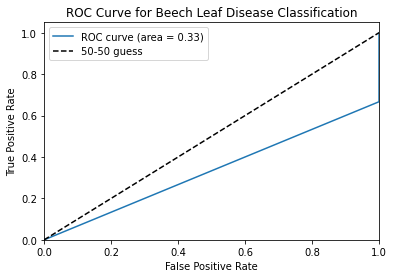

In [25]:
# Plot the ROC curve
#fpr is hist[7]
#tpr is hist[8]
#roc_auc is hist[9]

plt.figure()  
plt.plot(hist[7], hist[8], label='ROC curve (area = %0.2f)' % hist[9])
plt.plot([0, 1], [0, 1], 'k--', label='50-50 guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Beech Leaf Disease Classification')
plt.legend()
plt.show()

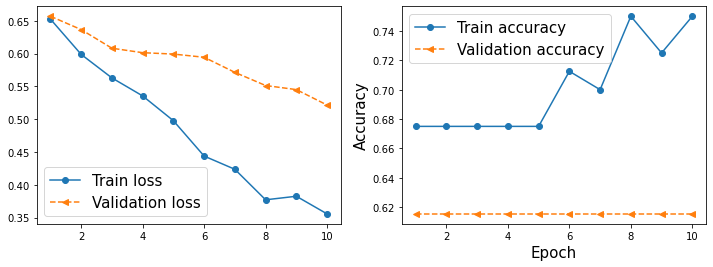

In [26]:
#Plot learning curve
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize = 15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train accuracy')
ax.plot(x_arr, hist[3], '--<',
        label='Validation accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size = 15)
ax.set_ylabel('Accuracy', size=15)
plt.show()




In [ ]:
#Gradcam
#https://medium.com/@evodopives/demystifying-cnn-decisions-a-practical-gradcam-implementation-in-pytorch-2d5692707b0d

features = None 
grads = None

# Forward hook: capture the output (feature maps)
def forward_hook(module, input, output):
    global features
    features = output.detach()

# Backward hook: capture the gradients from the output
def backward_hook(module, grad_in, grad_out):
    global grads
    grads = grad_out[0].detach()

In [ ]:
#import model

weights = ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)
model.eval()

# Identify the last convolutional layer
target_layer = model.layer4[-1]

target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

In [ ]:
#model.eval()

In [ ]:
img_path = '/project/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07461 - Copy.jpg' 
img = Image.open(img_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

In [ ]:
output = model(input_tensor)

# Choose a class index (e.g., for demonstration)
class_idx = 0
score = output[0, class_idx]

model.zero_grad()
score.backward()

In [ ]:
# Compute weights: global average pooling over gradients
weights = torch.mean(grads, dim=(2, 3))  # Shape: [batch, channels]

# Compute the weighted combination of feature maps
cam = torch.sum(weights.unsqueeze(-1).unsqueeze(-1) * features, dim=1)

cam = F.relu(cam)

# Normalize the CAM to [0, 1]
cam = cam - cam.min()
cam = cam / cam.max()

In [ ]:
cam_np = cam[0].cpu().numpy()
cam_np = cv2.resize(cam_np, (224, 224))
cam_np = np.uint8(255 * cam_np)

# Apply a colormap (JET) and convert color channels from BGR to RGB
heatmap = cv2.applyColorMap(cam_np, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

img_np = np.array(img.resize((224, 224)))

# Overlay: 40% heatmap and 60% original image
overlay = heatmap * 0.4 + img_np * 0.6
overlay = np.uint8(np.clip(overlay, 0, 255))

plt.imshow(overlay)
plt.axis('off')
plt.show()